# Sentiment Analysis

## Part 2: Word Embeddings and Neural Network

In this notebook you will learn a powerful method to represent word in the numerical way and apply it to a simply 2-layer network for classification.

**Outline**:

- SVM
- Logistic Regression
- Neural Network
- Word Embedding

*Some codes are adapted from [deeplearning.ai](https://www.deeplearning.ai/). Please do not use the code for ANY commercial use.*

**Pipeline**

<img src="resources/pipeline.png" width="800px">

## SVM

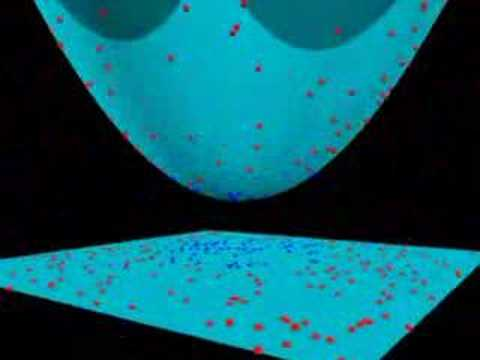

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('3liCbRZPrZA')

In [ ]:
# Import necessary packages

import pickle
import pandas as pd

from sklearn.svm import LinearSVC
from sklearn import metrics

from ml_utils import *

In [ ]:
# Load tf vectors we got last week
with open('tf_vec.pkl', 'rb') as fp:
    tf_vec = pickle.load(fp)

In [ ]:
def load_data(path):
    data = pd.read_csv(path)
    return data['reviewText'].tolist(), data['sentiment'].tolist()

In [ ]:
# Load data
train_x, train_y = load_data('data/pptrain.csv')
test_x, test_y = load_data('data/pptest.csv')

In [ ]:
# Convert text to vectors
train_features = tf_vec.transform(train_x)
test_features = tf_vec.transform(test_x)

In [ ]:
svm_model = LinearSVC()
svm_model.fit(train_features, train_y)

In [ ]:
pred = svm_model.predict(test_features)

In [ ]:
accuracy = metrics.accuracy_score(pred,test_y)
print(accuracy)

In [ ]:
print(metrics.classification_report(y_true=test_y, y_pred=pred))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
y_score = svm_model.decision_function(test_features)

In [ ]:
y_test_bin = [1 if y == 'pos' else 0 for y in test_y]

In [ ]:
precisions, recalls, _ = metrics.precision_recall_curve(y_test_bin, y_score)

In [ ]:
plot_pr_curve(precisions, recalls)

In [ ]:
fprs, tprs, _ = metrics.roc_curve(y_test_bin, y_score)
roc_auc = metrics.auc(fprs, tprs)

print('roc_auc = ', roc_auc)

In [ ]:
plot_roc_curve(fprs, tprs, roc_auc)

<span style="color:red">**Note:**</span>

For Simple Negation Handling: [Fast and accurate sentiment classification using an enhanced Naive Bayes model](https://pdfs.semanticscholar.org/c7a6/53d57e7f6686a13a37463f5e04e2916a5170.pdf)

## Logistic Regression

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$

### Forward Propagation

- Calculate $A = \hat{Y} = \sigma(w^T X + b)$
- Calculate `cost`: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

### Back Propagation:

- Calculate grad `dw`: $\frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$
- Calculate grad `db`: $\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$

> `sigmoid` is already provided in **ml_utils.py**.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Calcualte cost and grad (dw, db)
# Put dw, db in a dict grad: {'dw': dw, 'db': db}

def propagate(w, b, X, Y):
    
    # Get number of training examples
    m = X.shape[1]
    
    # Get activation
    A = sigmoid(np.dot(w.T, X) + b)
    
    # Compute cost
    cost = -1/m * np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))
    
    # Compute grad
    dw = 1/m * np.dot(X, (A-Y).T)
    db = 1/m * np.sum(A-Y)
    
    grads = {'dw': dw, 'db': db}
    
    return grads, cost

### Optimize (Gradient Descent)

<table>
    <tr>
        <td><img src="resources/gd1.gif" alt="https://giphy.com/gifs/gradient-6QlTwkigqg4yk"></td>
        <td><img src='resources/gd2.gif' alt="http://songhuiming.github.io/pages/2017/05/13/gradient-descent-in-solving-linear-regression-and-logistic-regression/"></td>
    </tr>
</table>

In [ ]:
def optimize(w, b, X, Y, num_iterations, learning_rate):
    costs = []
    
    for i in range(num_iterations):
        
        # Forward & Backward prop
        grads, cost = propagate(w, b, X, Y)
        dw = grads['dw']
        db = grads['db']

        w = w - learning_rate * dw
        b = b - learning_rate * db

        if i % 100 == 0:
            costs.append(cost)
        
    params = {'w': w, 'b': b}
    grads = {'dw': dw, 'db': db}
    
    return params, grads, costs

### Predict

In [ ]:
def lr_predict(w, b, X):
    A = sigmoid(np.dot(w.T, X) + b) # np.array (1, X.shape[1])
    return (A[0, :] > 0.5)

### Build the Model

In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5):
    
    # Initialize w, b
    w, b = np.zeros((X_train.shape[0], 1)), 0
    
    # Optimize
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate)
    w = params['w']
    b = params['b']
    
    # Test on training set and test set
    Y_prediction_test = lr_predict(w, b, X_test)
    Y_prediction_train = lr_predict(w, b, X_train)
    
    d = {
        'costs': costs,
        'Y_prediction_test': Y_prediction_test,
        'Y_prediction_train': Y_prediction_train,
        'w': w,
        'b': b,
    }
    
    return d

### Test on Iris dataset

In [ ]:
# Load data
X_train, X_test, Y_train, Y_test = load_iris()

# Plot data
plt.scatter(X_train[0,:], X_train[1, :], c=Y_train[0], cmap=plt.cm.Spectral)

In [ ]:
d = model(X_train, Y_train, X_test, Y_test, learning_rate=0.005)

In [ ]:
print_test_report(d, Y_train, Y_test)

## Neural Network

### Logistic Regression (1-layer neural network)

<img src="resources/1-layer-nn.png">

<br>
<center>A 1-layer neural network: Logistic Regression</center>

In [ ]:
X_train, X_test, Y_train, Y_test = load_moon()
plt.scatter(X_train[0,:], X_train[1,:],c=Y_train[0],cmap=plt.cm.Spectral)

In [ ]:
d = model(X_train, Y_train, X_test, Y_test, learning_rate=0.005, num_iterations=8000)

In [ ]:
print_test_report(d, Y_train, Y_test)

In [ ]:
plot_decision_boundary(lambda x: lr_predict(d['w'], d['b'], x.T), X_train, Y_train)

<span style="color:red">**Notes:**</span>

Logitic regression works not so well when features are not linearly separable. It depends heavily on features, so feature engineering is essential if you are using LR.

### A 2 - Layer Neural Network

<img src="resources/2-layer-nn.png">

<br>
<center>A 2-layer neural network: 1 hidden layer + 1 output layer</center>

In [ ]:
def forward_propagation(X, parameters):
    
    # Get parameters from dict
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Forward propagation
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    # Cache results that can be used later
    cache = {
        'Z1': Z1,
        'A1': A1,
        'Z2': Z2,
        'A2': A2
    }
    
    return A2, cache

- Calculate `cost`: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

In [ ]:
def compute_cost(A2, Y, parameters):
    m = Y.shape[1]
    cost = -1/m * np.sum(np.multiply(np.log(A2), Y) + np.multiply(np.log(1-A2), 1-Y))
    return np.squeeze(cost)

In [ ]:
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    
    # Get parameters from dict
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    A1 = cache['A1']
    A2 = cache['A2']
    
    # Back propagation
    dZ2 = A2 - Y
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True) 
    
    dZ1 = np.dot(W2.T, dZ2) * (1-np.power(A1, 2))
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    
    # Save results for display
    grads = {
        'dW1': dW1,
        'dW2': dW2,
        'db1': db1,
        'db2': db2,
    }
    
    return grads

In [ ]:
def update_parameters(parameters, grads, learning_rate=1.0):
    # Get parameters from dict
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Get derivative from dict
    dW1 = grads['dW1']
    dW2 = grads['dW2']
    db1 = grads['db1']
    db2 = grads['db2']
    
    # Gradient descent, update parameters
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2
    }
    
    return parameters

In [ ]:
def nn_model(X, Y, n_h, num_iterations=10000):
    n_x, n_y = X.shape[0], Y.shape[0]
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    parameters = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2
    }
    
    for i in range(num_iterations):
        
        # Step 1: forward propagation
        A2, cache =  forward_propagation(X, parameters)
        
        # Step 2: compute cost
        cost = compute_cost(A2, Y, parameters)
        
        # Step 3: compute grad
        grads = backward_propagation(parameters, cache, X, Y)
        
        # Step 4: update parameters (grdient descent)
        parameters = update_parameters(parameters, grads)
        
    return parameters

In [ ]:
def nn_predict(parameters, X):
    A2, _ = forward_propagation(X, parameters)
    return (A2 > 0.5)

In [ ]:
parameters = nn_model(X_train, Y_train, n_h = 4)

In [ ]:
plot_decision_boundary(lambda x: nn_predict(parameters, x.T), X_train, Y_train)

### Word Embedding

<img src="resources/word-vector.png" width="800">

In [ ]:
word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

In [ ]:
X_train, X_test, Y_train, Y_test = load_emoji()

In [ ]:
# Print the first 5 samples
for i in range(5):
    print(X_train[i], label_to_emoji(Y_train[i]))

In [ ]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [ ]:
print(Y_train[0], "is converted into one hot", Y_oh_train[0])

<img src="resources/word_embedding_1.png" width="800">

In [ ]:
def sentence_to_avg(sentence, word_to_vec_map):
    
    # Convert a sentence string into the average of word vector (dim = 50)
    words = sentence.lower().split()
    
    avg = np.zeros((50,))
    cnt = 0
    for w in words:
        avg += word_to_vec_map.get(w, np.zeros((50,)))
        cnt += 1
    avg = avg / cnt
    
    return avg

In [ ]:
avg = sentence_to_avg("I like it", word_to_vec_map)
print("avg = ", avg)

### Model

Assuming here that $Yoh$ ("Y one hot") is the one-hot encoding of the output labels, the equations you need to implement in the forward pass and to compute the cross-entropy cost are:
$$ z^{(i)} = W . avg^{(i)} + b$$
$$ a^{(i)} = softmax(z^{(i)})$$
$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Yoh^{(i)}_k * log(a^{(i)}_k)$$

> `softmax()` is provided.

In [ ]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    np.random.seed(1)

    m = Y.shape[0]                          # number of training examples
    n_y = 5                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    # Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization
    for t in range(num_iterations):                       # Loop over the number of iterations
        for i in range(m):                                # Loop over the training examples
            
            # Step 0: sentence to average vector
            avg = sentence_to_avg(X[i], word_to_vec_map)
            
            # Step 1: forward propagation
            z = np.dot(W, avg) + b
            a = softmax(z)
            
            # Step 2: compute cost
            cost = -np.sum(Y_oh[i] * np.log(a))
            
            # Step 3: compute grad
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz
            
            # Step 4: update parameters (grdient descent)
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [ ]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)

In [ ]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

In [ ]:
X_my_sentences = np.array([
    "you romanced me", 
    "you are horrible", 
    "funny lol", 
    "lets play with a ball", 
    "food is ready", 
    "not feeling happy"])
Y_my_labels = np.array([[0], [3], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)